In [1]:
# Import tools

import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from tensorflow import keras


## Read the data

In [2]:

# Load the data and preprocess as needed

file_path = '../magic04.data'
column_names = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"]
data = pd.read_csv(file_path, header=None, names=column_names)


In [3]:
data

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g
...,...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,h
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,h
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,h
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,h


## Data cleaning and preprocessing

In [4]:
data.isnull().any()

fLength     False
fWidth      False
fSize       False
fConc       False
fConc1      False
fAsym       False
fM3Long     False
fM3Trans    False
fAlpha      False
fDist       False
class       False
dtype: bool

### Label encoding for class column

In [5]:
label_encoder = LabelEncoder()
data['class'] = label_encoder.fit_transform(data['class'])

In [6]:
data['class'].unique()

array([0, 1])

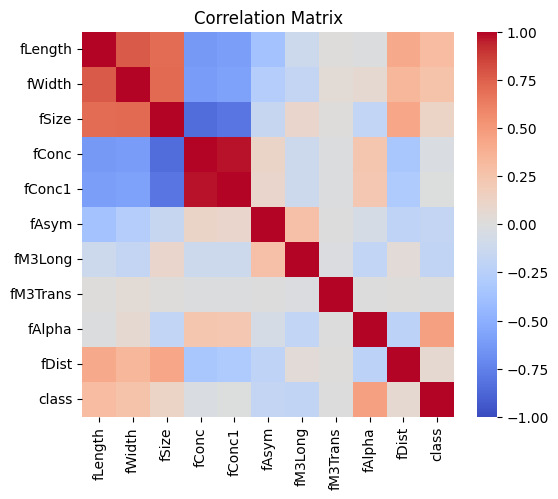

In [7]:
# Create correlation matrix 

corr_matrix = data.corr()

target_corr = corr_matrix['class']

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show() 

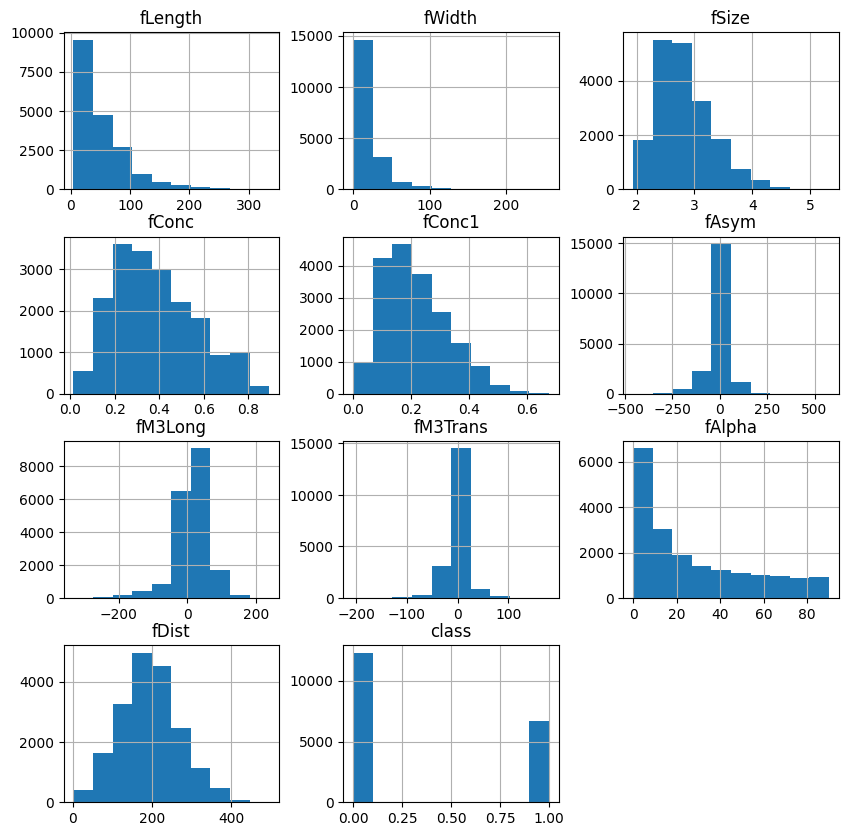

In [8]:
# Visualize each attributes 

plt.rcParams["figure.figsize"] = (10, 10)
data.hist()
plt.grid()

### Split data into training and testing

In [9]:
X = data.drop('class', axis=1)
y = data['class']

# Split the data into train and test sets (2/3 - 1/3 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Based on the distribution of the values, we can see that the attribute class is imbalance. Hence, I will do Min-Max scaling on this data set. 

### SMOTE

In [10]:
# Apply SMOTE 

smote = SMOTE(random_state=42)

# Apply SMOTE only to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [11]:
# Standardize the data 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Convert to data type for tensorflow

In [12]:
# Convert Pandas DataFrames to NumPy arrays
X_train_scaled = np.array(X_train_scaled)
X_test_scaled = np.array(X_test_scaled)
y_train_resampled = np.array(y_train_resampled)
y_test = np.array(y_test)

## Build the ANN Model

In [13]:
import keras
from keras import regularizers
from keras.layers import Dense
from keras import metrics

# Build the ANN model
optimizer = keras.optimizers.Adam()

def build_model(n_hidden=3, n_neurons=32, a=0.001, b=0.002):
    model = keras.Sequential()
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation='relu', kernel_regularizer=regularizers.L1L2(l1=a, l2=b)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=[metrics.MeanSquaredError()])
    return model

In [14]:
# Train the model

model = build_model()

history = model.fit(X_train_scaled, 
                    y_train_resampled, 
                    epochs=10, 
                    batch_size=32, 
                    validation_split=0.1)

Epoch 1/10
359/359 [==============================] - 1s 1ms/step - loss: 0.4869 - mean_squared_error: 0.1488 - val_loss: 0.3269 - val_mean_squared_error: 0.1270
Epoch 2/10
359/359 [==============================] - 0s 738us/step - loss: 0.2617 - mean_squared_error: 0.1185 - val_loss: 0.2205 - val_mean_squared_error: 0.1177
Epoch 3/10
359/359 [==============================] - 0s 724us/step - loss: 0.1935 - mean_squared_error: 0.1128 - val_loss: 0.1778 - val_mean_squared_error: 0.1144
Epoch 4/10
359/359 [==============================] - 0s 730us/step - loss: 0.1633 - mean_squared_error: 0.1103 - val_loss: 0.1586 - val_mean_squared_error: 0.1137
Epoch 5/10
359/359 [==============================] - 0s 769us/step - loss: 0.1475 - mean_squared_error: 0.1078 - val_loss: 0.1478 - val_mean_squared_error: 0.1122
Epoch 6/10
359/359 [==============================] - 0s 730us/step - loss: 0.1390 - mean_squared_error: 0.1061 - val_loss: 0.1408 - val_mean_squared_error: 0.1101
Epoch 7/10
359/359

### Visualize the loss during fitting the model 

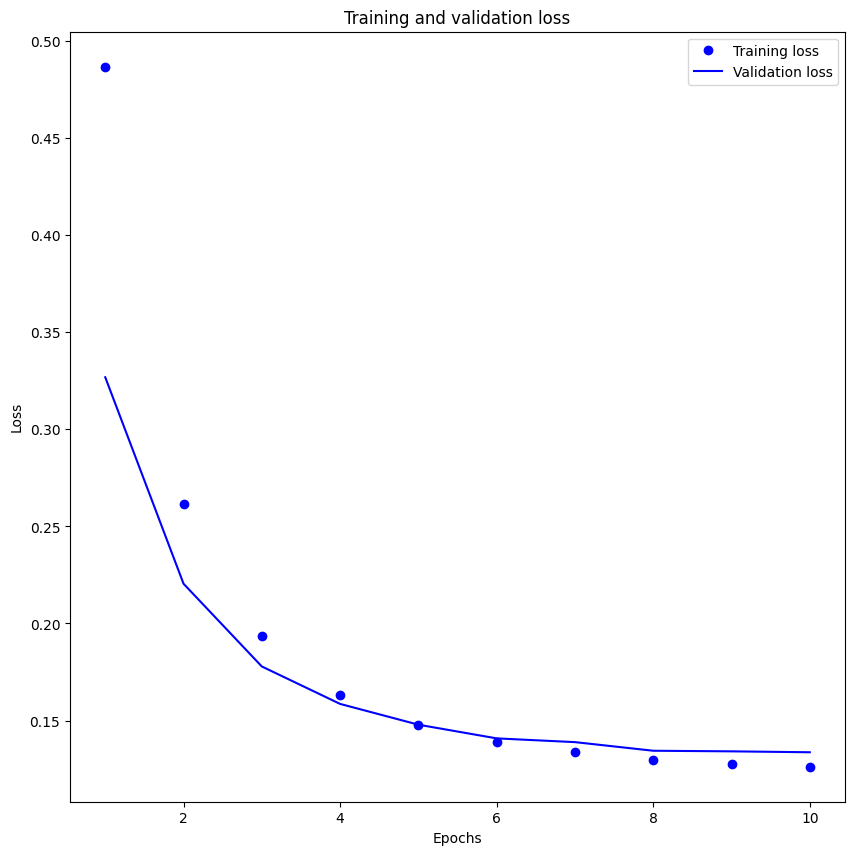

In [16]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [14]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)
y_pred_class = np.round(y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_class)

print("Test Accuracy:", accuracy)


197/197 [==============================] - 0s 481us/step
Test Accuracy: 0.8586904572247889


## Fine tune the model

In [18]:
param_distribs = {
    'n_hidden': [2,4,6],
    'n_neurons': [32,64,128],
    'a': [0.0002, 0.001, 0.005],
    'b': [0.0002, 0.001, 0.005]
}

In [23]:
# Create the KerasRegressor
keras_reg = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=build_model)

# Create the GridSearchCV object
search_cv = GridSearchCV(keras_reg, param_distribs, cv=3, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to your data
search_cv.fit(X_train_scaled, y_train_resampled, epochs=60, validation_data=(x_val, y_val), \
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=30)])

# Get the best parameters and best score
best_params = search_cv.best_params_
best_score = search_cv.best_score_

# Get the best model
best_model = search_cv.best_estimator_.model

AttributeError: module 'tensorflow.keras' has no attribute 'wrappers'

In [ ]:
# Make predictions on the test set
y_pred = best_model.predict(X_test_scaled)
y_pred_class = np.round(y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_class)

print("Test Accuracy:", accuracy)